<a href="https://colab.research.google.com/github/OmerDiaaeldin/NeuralNetwork/blob/main/Canny_Edge_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Canny Edge detection</h1>

<h3>Image preprocessing</h3>

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
import numpy as np
from scipy import misc
import imageio
from matplotlib import image
import matplotlib.pyplot as plt

path = "/content/Strawberry_ice_cream_cone_(5076899310).jpg"

def import_img_and_convert_to_grayscale(path = path):
  rgb = image.imread(path)
  img = np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
  plt.figure(figsize=(120,10))
  plt.imshow(img, cmap=plt.get_cmap('gray'))
  plt.show()
  return img

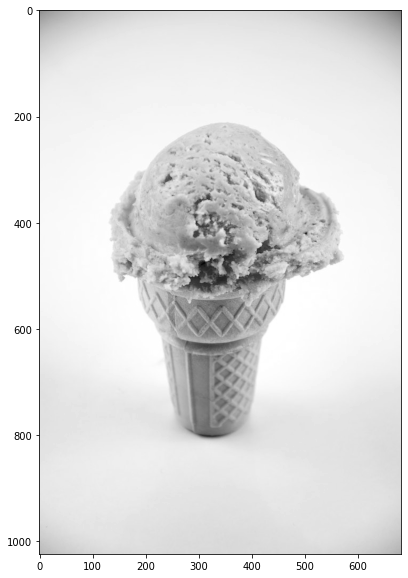

(1024, 681)

In [ ]:
img = import_img_and_convert_to_grayscale();
display(img.shape)

<h3>Filter the image</h3>

In [ ]:
from scipy.ndimage import convolve

kernel = 15
sigma = 1.4

def filter_image(img, kernel=kernel, sigma=sigma):
  size = int(kernel) // 2
  x, y = np.mgrid[-size:size+1, -size:size+1]
  normal = 1 / (2.0 * np.pi * sigma**2)
  filter =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
  filtered_img = convolve(img, filter, mode='reflect')
  plt.figure(figsize=(120,10))
  plt.imshow(filtered_img, cmap=plt.get_cmap('gray'))
  plt.show()
  return filtered_img

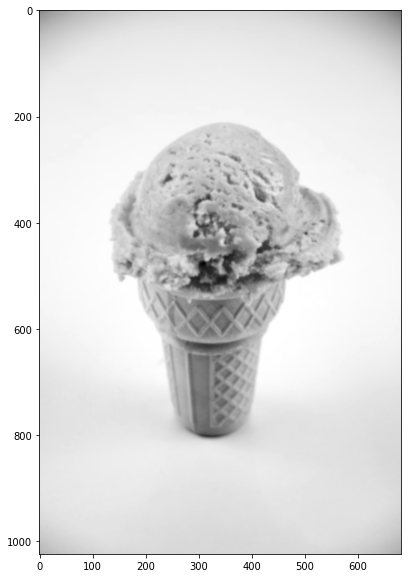

254.97449999999998

10.4615

In [ ]:
filtered_img = filter_image(img, kernel, sigma)
display(np.max(img))
display(np.min(img))

<h3>Gradient Map</h3>

In [ ]:
#create a gradient map of the image using sobel operator
from scipy.signal import convolve2d

def create_gradient_img(img=filtered_img):
  a1 = np.matrix([1, 2, 1])
  a2 = np.matrix([-1, 0, 1])
  Kx = a1.T * a2
  Ky = a2.T * a1

  Gx = convolve2d(img, Kx, "same", "symm")
  Gy = convolve2d(img, Ky, "same", "symm")
  G_mag = np.sqrt(Gx**2+Gy**2)
  G_dir = np.arctan2(Gy,Gx)*(180)/np.pi
  
  plt.figure(figsize=(120,10))
  plt.imshow(G_mag, cmap = plt.get_cmap('gray'))
  plt.show()
  return [G_mag, G_dir]

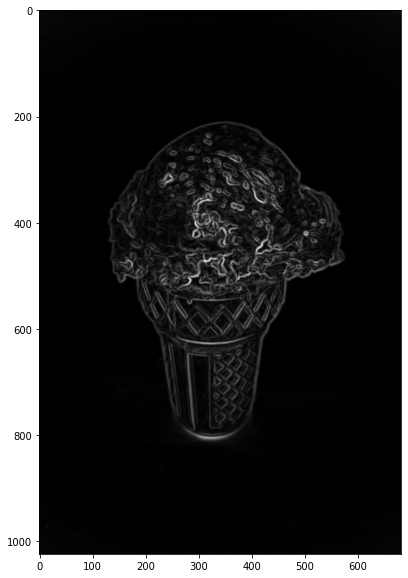

In [ ]:
magnitude_map, direction_map = create_gradient_img()

In [ ]:
display(np.max(magnitude_map))
display(np.min(magnitude_map))

310.425582045803

0.0

In [ ]:
display(np.max(direction_map))
display(np.min(direction_map))

180.0

-179.99999999999875

In [ ]:
for row in range(direction_map.shape[0]):
  for column in range(direction_map.shape[1]):
    gradient = abs(direction_map[row][column])
    if(gradient <=22.5):
      direction_map[row][column] = 0
    elif(gradient <=67.5):
      direction_map[row][column] = 45
    elif(gradient <=112.5):
      direction_map[row][column] = 90
    elif(gradient <=157.5):
      direction_map[row][column] = 135
    elif(gradient <=180):
      direction_map[row][column] = 0

In [ ]:
display(np.max(direction_map))
display(np.min(direction_map))
display(np.unique(direction_map))

135.0

0.0

array([  0.,  45.,  90., 135.])

<h3>Non-max suppression</h3>

In [ ]:
for row in range(direction_map.shape[0]):
  for column in range(direction_map.shape[1]):
    mag = magnitude_map[row][column]
    dir = direction_map[row][column]

    if(dir == 0):
      c = 1
      s = 0
    elif(dir == 45.0):
      c = 1
      s = 1
    elif(dir == 90):
      c = 0
      s = 1
    elif(dir == 135):
      c = -1
      s = 1

    x2 = row + c
    y2 = column + s
    x1 = row - c
    y1 = column - s

    try:
      neighbour = magnitude_map[x2][y2]
      if(neighbour > mag):
        magnitude_map[row][column] = 0
    except:
      pass
    
    try:
      neighbour = magnitude_map[x1][y1]
      if(neighbour > mag):
        magnitude_map[row][column] = 0
    except:
      pass
      


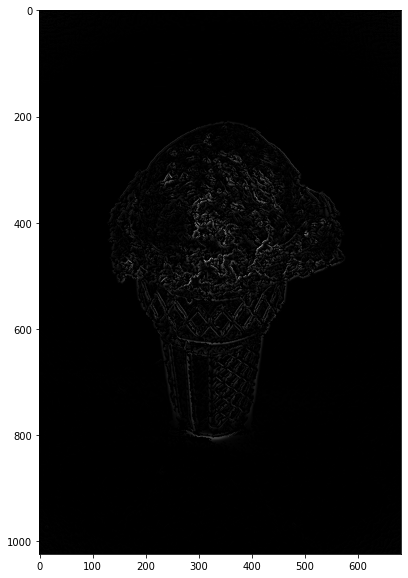

In [ ]:
plt.figure(figsize=(120,10))
plt.imshow(magnitude_map, cmap=plt.get_cmap("gray"))

<h3>Double threshold</h3>

In [ ]:
strong_threshold = 0.09*255*2
weak_threshold = 0.05*255

def double_threshold(img, strong=strong_threshold,weak=weak_threshold):
  X = np.zeros(img.shape)
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      x = img[i][j]
      if(x >= strong):
        X[i][j] = 255
      elif(x>=weak):
        X[i][j] = 25

  return X

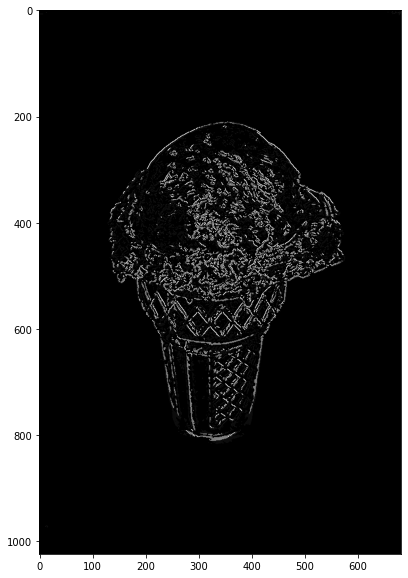

In [ ]:
threshed_img = double_threshold(magnitude_map)
plt.figure(figsize=(120,10))
plt.imshow(threshed_img,cmap = plt.get_cmap("gray"))

<h3>blob analysis</h3>

In [ ]:
#This is pretty much how it goes:
#we have a 2d array containing (strong elements)255's, (weak elements)25's, and (empty elements) zeros
# what we want to do is go through the whole array, and every weak element that is near a
#strong element is immedialty marked as strong (255)
#all other weak elements left are marked as empty

def BFS(node, img, visited):
  row = node[0]
  column = node[1]
  if(visited[row][column] == 1):
    return None

  visited[row][column] = 1
  if(img[row][column] == 25):
    img[row][column] = 255

  if(img[row][column] == 0):
    return None

  for i in range(-1,2):
    for j in range(-1,2):
      try:
        BFS((row+i,column+i), img, visited)
      except:
        pass

def blob(image):
  img = np.ndarray.copy(image)
  strong = [] #list of coordinates of strong elements
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if img[i][j] == 255:
        strong.append((i,j))

  visited = np.zeros(img.shape)

  for element in strong:
    BFS(element, img, visited)

  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if img[i][j] == 25:
        img[i][j] = 0

  return img

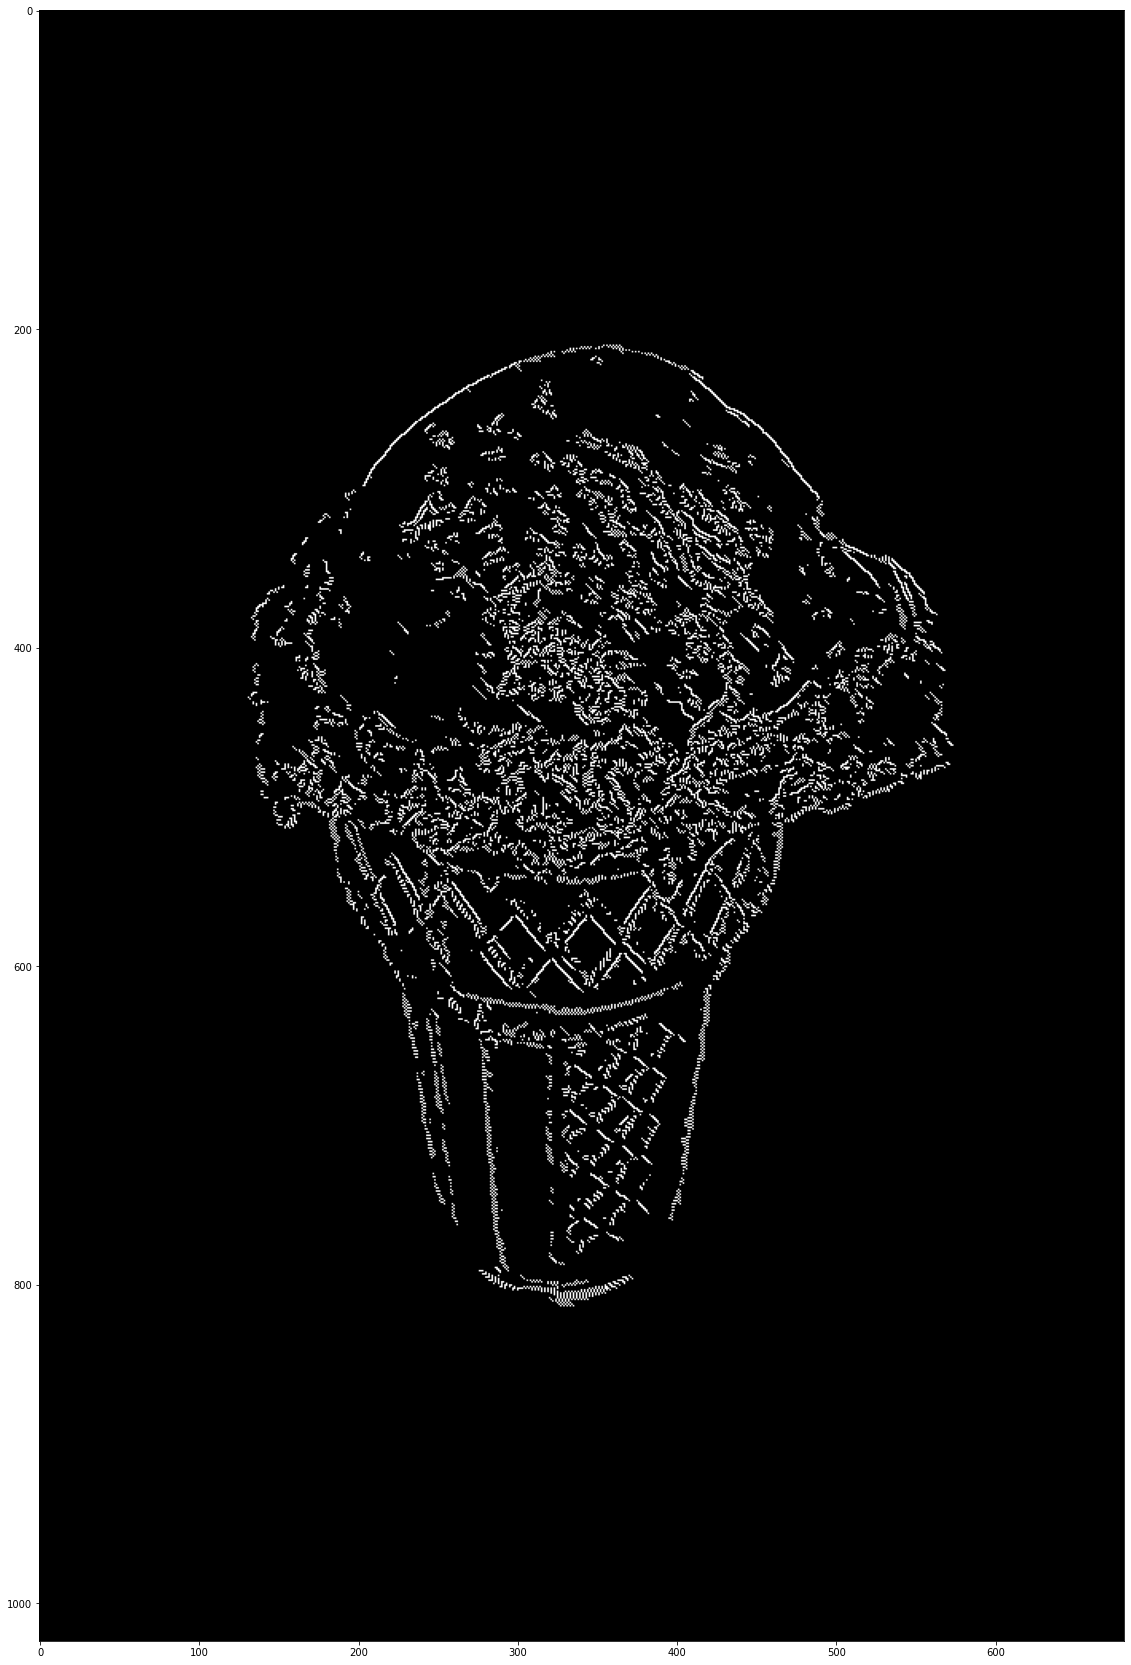

In [ ]:
final_img = blob(threshed_img)
plt.figure(figsize=(360,30))
plt.imshow(final_img,cmap = plt.get_cmap("gray"))
plt.show()

In [ ]:
print(np.unique(threshed_img, return_counts=True))
print(np.unique(final_img, return_counts=True))
print(np.unique((final_img==threshed_img),return_counts=True))

(array([  0.,  25., 255.]), array([659750,  21773,  15821]))
(array([  0., 255.]), array([679553,  17791]))
(array([False,  True]), array([ 21773, 675571]))


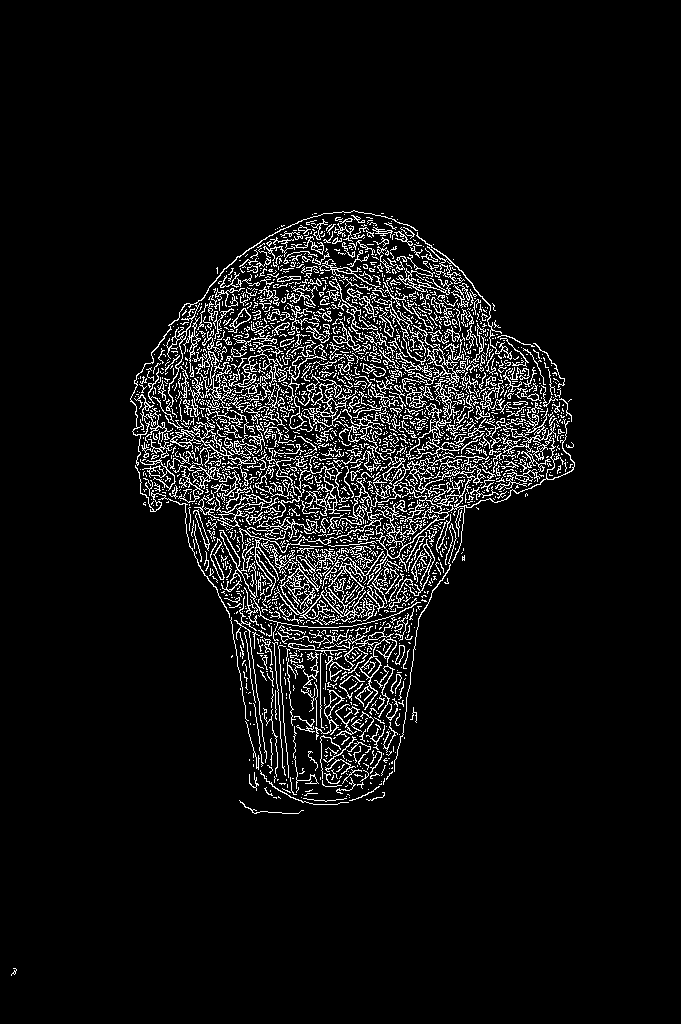

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread(path)

edge = cv2.Canny(img, weak_threshold, strong_threshold)

cv2_imshow(edge)